### Split Dataset For Model Development Exercise
In this exercise, we're going to prepare a dataset to be fed into a classification model for training. You're given a dataframe with image labels for 5,000 chest x-rays. Your goal is to prepare a training and a validation dataset for an algorithm that predicts the presence of a Pneumothorax (collapsed lung). Remember, we want our model to see an equal amount of positive and negative cases when it's training, but when we evaluate its performance, we should be looking at a class balance or imbalance that is more reflective of the real world. In this exercise,

You will notice that Pneumothorax isn't a very common finding in this dataset, so you'll want to maximize your data so that you can use all of the true Pneumothorax cases in training. Given the large class imbalances, however, you may end up throwing away images that don't contain Pneumothorax.

Here's an assumption you can make when creating your validation set: Despite the large imbalance of Pneumothorax in this dataset, in the actual clinical setting where you want to deploy your algorithm, the prevalence of Pneumothorax will be about 20%. This is because patients are only being x-rayed based on their clinical symptoms that make Pneumothorax highly likely.

The final output of this exercise should be two dataframes: one containing data for training your algorithm, and one containing data for validating your algorithm.

In [30]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

from itertools import chain
from random import sample 
import scipy

import sklearn.model_selection as skl
# Set seaborn style
sns.set_theme()


## 1. Read the Data
First read in the dataframe. You'll notice it's similar to the dataframe that you ended the final solution with in Lesson 2, Exercise 4, only with more data:

In [31]:
d = pd.read_csv('findings_data_5000.csv')
d.head()

,Unnamed: 0,Finding Labels,Patient ID,Patient Age,Patient Gender,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,1,Cardiomegaly|Emphysema,1,57,M,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,No Finding,2,77,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,Atelectasis,3,79,M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Cardiomegaly|Edema|Effusion,4,55,F,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Consolidation|Mass,5,68,M,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 2. Understand the Distribution
Just like in Lesson 2, Exercise 4, we want to see how different diseases are distributed with our disease of interest, as well as how age and gender are distributed:

In [32]:
all_labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

[Text(0, 0.5, 'Number of Images with Label')]

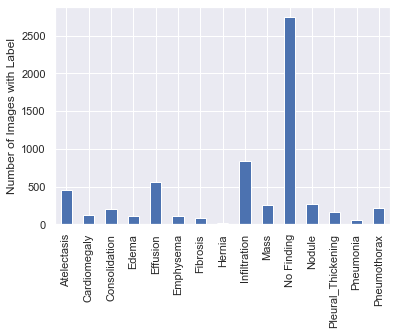

In [33]:
ax = d[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

<AxesSubplot:>

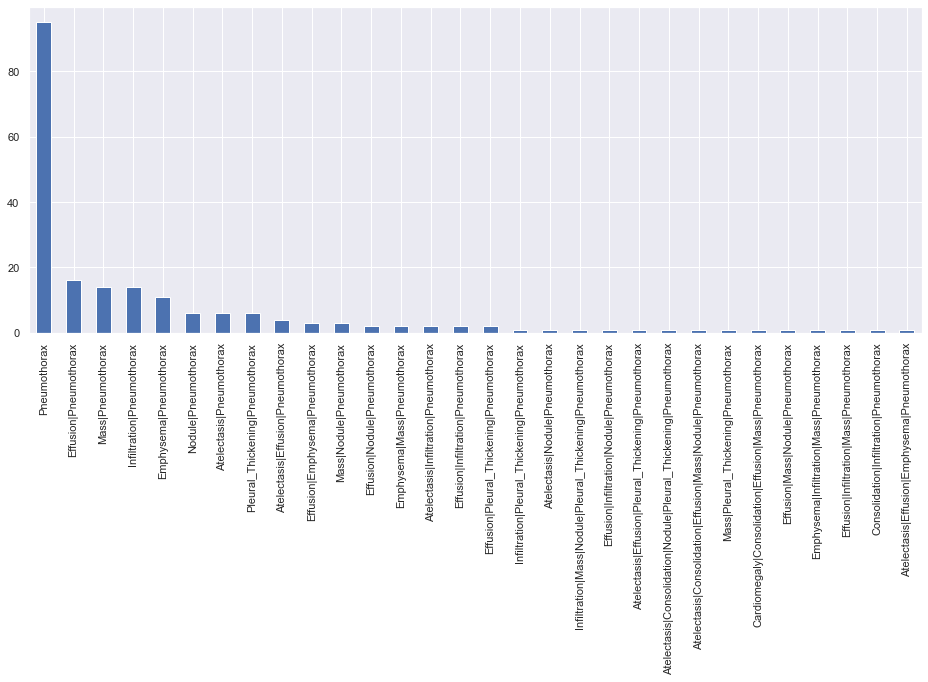

In [34]:
plt.figure(figsize=(16,6))
d[d.Pneumothorax==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

<AxesSubplot:>

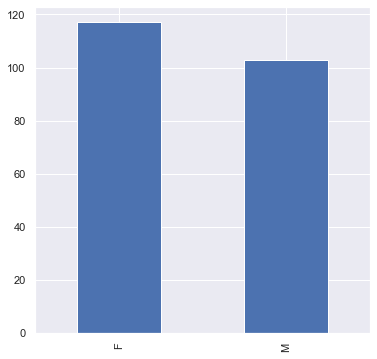

In [35]:
plt.figure(figsize=(6,6))
d[d.Pneumothorax ==1]['Patient Gender'].value_counts().plot(kind='bar')

(array([12., 18., 13., 21., 20., 47., 50., 26.,  9.,  4.]),
 array([ 7. , 14.6, 22.2, 29.8, 37.4, 45. , 52.6, 60.2, 67.8, 75.4, 83. ]),
 <BarContainer object of 10 artists>)

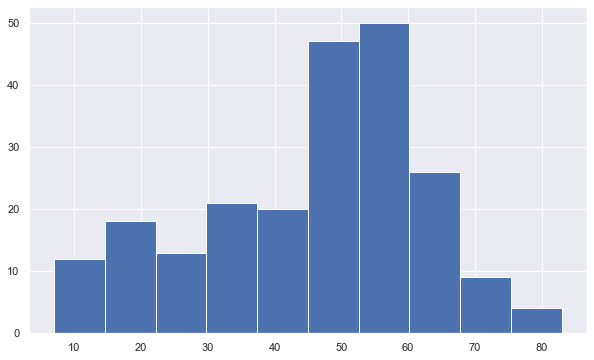

In [36]:
plt.figure(figsize=(10,6))
plt.hist(d[d.Pneumothorax==1]['Patient Age'])

## 3. Split the Data into Train/Test Partitions
Now, knowing what we know from above, let's create the appropriate training and validation sets for a model that we want to train to classify the presence of a Pneumothorax

In [37]:
train_df, valid_df = skl.train_test_split(d, 
                                   test_size = 0.2, 
                                   stratify = d['Pneumothorax'])

In [38]:
train_df['Pneumothorax'].sum()/len(train_df)

0.04401100275068767

In [39]:
valid_df['Pneumothorax'].sum()/len(valid_df)

0.044

Great, our train_test_split made sure that we had the same proportions of Pneumothorax in both sets!

### Condition 1 - To have _EQUAL_ amount of positive and negative cases of Pneumothorax in Training 
But.... we know that we want our model to be trained on a set that has _equal_ proportions of pneumothorax and no pneumothorax, so we're going to have to throw away some data:

In [40]:
p_inds = train_df[train_df.Pneumothorax==1].index.tolist()
np_inds = train_df[train_df.Pneumothorax==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [41]:
train_df['Pneumothorax'].sum()/len(train_df)

0.5

Ta-da! We randomly chose a set of non-Pneumothorax images using the sample() function that was the same length as the number of true Pneumothorax cases we had, and then we threw out the rest of the non-Pneumothorax cases. Now our training dataset is balanced 50-50.

### Condition 2 - To have 20% positive cases of Pneumothorax in the Test Set
Finally, we want to make the balance in our validation set more like 20-80 since our exercise told us that the prevalence of Pneumothorax in this clinical situation is about 20%:

In [42]:
p_inds = valid_df[valid_df.Pneumothorax==1].index.tolist()
np_inds = valid_df[valid_df.Pneumothorax==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [43]:
valid_df['Pneumothorax'].sum()/len(valid_df)

0.2